# Module 1.09: Diagnostics — The Big Picture

> **Goal:** Compute time series diagnostics and understand what patterns exist in our portfolio.

**5Q Lens:** Q4 (Data & Drivers) — Measure structure & chaos across portfolio

### Complete ≠ Forecastable

Module 1.08 gave us clean, gap-free data. But a complete timeline can still be impossible to forecast.

| 1.08 Asked | 1.09 Asks |
|------------|-----------|
| Is the data *present*? | Is there *signal*? |
| Are there gaps? | Is there trend? Seasonality? |
| Is the timeline regular? | Is it predictable or chaotic? |

Diagnostics reveal what the data *is* — before we ask a model to predict it.


---

## 1. Setup

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tsfeatures import tsfeatures
import forecast_foundations as ff
from forecast_foundations import ModuleReport
from tsforge.eda.ts_features_extension import ADI
import tsforge as tsf
from tsforge.plots import plot_metric_distribution
# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Environment
env = ff.setup_notebook()
DATA_DIR = env.DATA_DIR
cache = env.cache
output = env.output

# # Colors: Structure vs Chaos
# COLORS = {
#     'structure': '#4A90A4',  # Dusty blue
#     'chaos': '#D4775D',      # Terra cotta
# }

✓ Setup complete | Root: real-world-forecasting-foundations | Notebook: 1.09_diagnostics | Data: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data | Cache: on


---
## 2. Load Data

In [2]:
# Load the forecast-ready dataset from Module 1.08
weekly_df = output.load('1_08_data_preparation')

✓ Loaded '1_08_data_preparation'
   Shape: 6,848,887 × 21


In [3]:
# Quick sanity check
weekly_df.head(3)

,unique_id,ds,y,is_gap,item_id,store_id,dept_id,cat_id,state_id,wm_yr_wk,...,year,snap_CA,snap_TX,snap_WI,event_name_1,event_name_2,event_name_3,event_type_1,event_type_2,event_type_3
0,FOODS_1_001_CA_1,2011-01-23,3.0,0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11101,...,2011,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,FOODS_1_001_CA_1,2011-01-30,9.0,0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11101,...,2011,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,FOODS_1_001_CA_1,2011-02-06,7.0,0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11102,...,2011,1,1,1,SuperBowl,NaN,NaN,Sporting,NaN,NaN


---

<div style="text-align: center;">

## 3. Compute Diagnostics

<div style="background: linear-gradient(135deg, #2E86AB 0%, #1a5276 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>What patterns exist in the data?</strong><br>
<em>50+ metrics from  tsfeatures + tsforge that describe trend, seasonality, noise, intermittency, and more.</em>
</div>

</div>

### 3.1 Calculate diagnostics from `tsfeatures`

`tsfeatures` extracts dozens of time series characteristics automatically — this is our first systematic look at the portfolio.

In [4]:
# Note: can be slow — show timing
# Compute diagnostics with caching to avoid recomputation

diagnostics = cache.load("diagnostics")

if diagnostics is None:
    diagnostics = tsfeatures(weekly_df, freq=52, threads=8)
    cache.save(diagnostics, key="diagnostics")

✓ Loaded 'diagnostics'
   Module: 1_09 | Shape: 30,490 × 43


### 3.2 Add ADI and CV²

`tsfeatures` doesn't include some important demand metrics:

- **ADI** (Average Demand Interval): Mean periods between non-zero demands
- **CV²** (Coefficient of Variation squared): Variability of demand sizes

These are essential for retail/CPG forecasting where zeros and demand volatility matter.

In [5]:
def get_adi(y):
    return ADI(y.values, freq=52)["adi"]

# Compute ADI per series
adi_df = (
    weekly_df
    .groupby('unique_id')['y']
    .apply(get_adi)
    .reset_index(name='adi')
)
adi_df

,unique_id,adi
0,FOODS_1_001_CA_1,1.105469
1,FOODS_1_001_CA_2,1.105469
2,FOODS_1_001_CA_3,1.118577
3,FOODS_1_001_CA_4,1.276018
4,FOODS_1_001_TX_1,1.200855
...,...,...
30485,HOUSEHOLD_2_516_TX_2,1.331754
30486,HOUSEHOLD_2_516_TX_3,1.944828
30487,HOUSEHOLD_2_516_WI_1,2.364407
30488,HOUSEHOLD_2_516_WI_2,4.892857


In [6]:
# Compute CV²
series_stats = (
    weekly_df
    .groupby('unique_id')['y']
    .agg(['mean', 'std'])
    .reset_index()
)
series_stats['cv2'] = (series_stats['std'] / series_stats['mean']).pow(2)

# Merge into diagnostics
diagnostics = (
    diagnostics
    .merge(series_stats[['unique_id', 'cv2']], on='unique_id', how='left')
    .merge(adi_df, on='unique_id', how='left')
)

diagnostics.head(3)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,cv2,adi
0,FOODS_1_001_CA_1,0.772978,283,-238.087160,0.464131,0.250347,0.0,0.0,0.165089,1,...,0.033894,0.333107,0.518003,-0.514709,0.302900,-0.685183,0.539962,-0.111695,0.505594,1.105469
1,FOODS_1_001_CA_2,0.827633,283,-203.367626,0.796027,0.267957,0.0,0.0,0.171234,1,...,0.061694,0.395002,0.634898,-0.450328,0.248609,-0.667034,0.555232,0.039438,0.503956,1.105469
2,FOODS_1_001_CA_3,0.797488,283,-253.771210,0.836479,0.151329,0.0,0.0,0.123224,1,...,0.066111,0.249157,0.244831,-0.464857,0.293540,-0.639856,0.514713,-0.042894,0.636649,1.118577


### 3.3 Merge Hierarchy Metadata

Attach business dimensions so we can slice diagnostics by department, category, store.

In [7]:
# Get hierarchy from original data
hierarchy = (
    weekly_df[['unique_id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
    .drop_duplicates(subset=['unique_id'])
)

# Merge
diagnostics = diagnostics.merge(hierarchy, on='unique_id', how='left')

### 3.4 Preview Key Metrics

In [8]:
KEY_METRICS = ['trend', 'seasonal_strength', 'entropy', 'adi', 'cv2']

diagnostics[['unique_id', 'cat_id', 'dept_id'] + KEY_METRICS].head(10)

,unique_id,cat_id,dept_id,trend,seasonal_strength,entropy,adi,cv2
0,FOODS_1_001_CA_1,FOODS,FOODS_1,0.204450,0.376623,0.850729,1.105469,0.505594
1,FOODS_1_001_CA_2,FOODS,FOODS_1,0.223280,0.439298,0.843529,1.105469,0.503956
2,FOODS_1_001_CA_3,FOODS,FOODS_1,0.162804,0.384099,0.895521,1.118577,0.636649
3,FOODS_1_001_CA_4,FOODS,FOODS_1,0.110839,0.479389,0.873170,1.276018,0.690184
4,FOODS_1_001_TX_1,FOODS,FOODS_1,0.260977,0.376637,0.866836,1.200855,0.828311
5,FOODS_1_001_TX_2,FOODS,FOODS_1,0.212788,0.397528,0.855971,1.156379,0.658129
6,FOODS_1_001_TX_3,FOODS,FOODS_1,0.048173,0.417552,0.886295,1.181435,0.630761
7,FOODS_1_001_WI_1,FOODS,FOODS_1,0.287522,0.423122,0.837675,1.119522,0.557075
8,FOODS_1_001_WI_2,FOODS,FOODS_1,0.392052,0.434856,0.828196,1.288991,0.875018
9,FOODS_1_001_WI_3,FOODS,FOODS_1,0.466792,0.466487,0.828913,1.524324,1.414375


---

<div style="text-align: center;">

## 4. Structure Metrics

<div style="background: linear-gradient(135deg, #4A90A4 0%, #2d5a6b 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Can we separate the signal from the noise?</strong><br>
<em>Trend + Seasonality = learnable patterns</em>
</div>

</div>

### 4.1 Trend Strength

Trend strength measures how much of the variance is explained by the trend component after STL decomposition.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Trend Strength Distribution'}, xlabel='Trend', ylabel='Density'>)

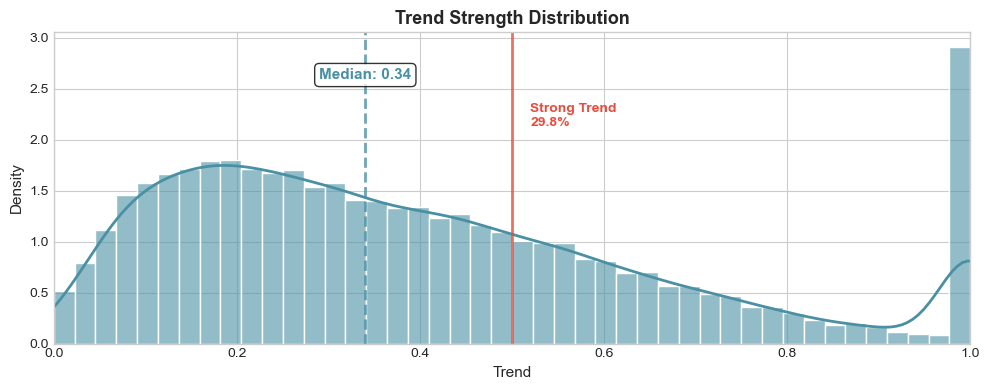

In [9]:
# Histogram of trend_strength
# What does the distribution tell us?
plot_metric_distribution(diagnostics, 'trend')

### 4.2 Seasonal Strength

**What it measures:** Repeating annual patterns (e.g., holiday spikes, summer dips).

**Higher = stronger seasonality.** Values above 0.6 indicate meaningful seasonal patterns.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Seasonal Strength Distribution'}, xlabel='Seasonal Strength', ylabel='Density'>)

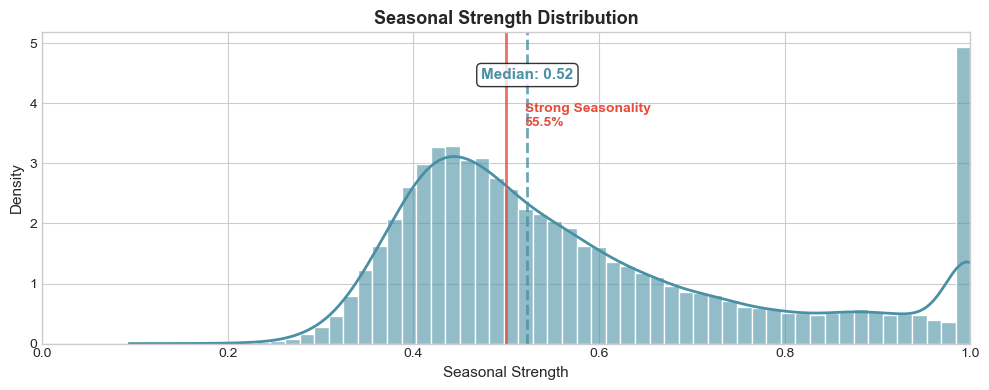

In [10]:
# Histogram of seasonal_strength
# How many series have strong seasonality?
plot_metric_distribution(diagnostics, 'seasonal_strength')

---

<div style="text-align: center;">

## 5.  Chaos Metrics

<div style="background: linear-gradient(135deg, #D4775D 0%, #8b4d3b 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>How unpredictable is the series?</strong><br>
<em>High chaos undermines even strong structure</em>
</div>

</div>

### 5.1 Entropy

**What it measures:** Randomness or disorder in the series.

**Higher = more random.** Low entropy means predictable structure.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Entropy Distribution'}, xlabel='Entropy', ylabel='Density'>)

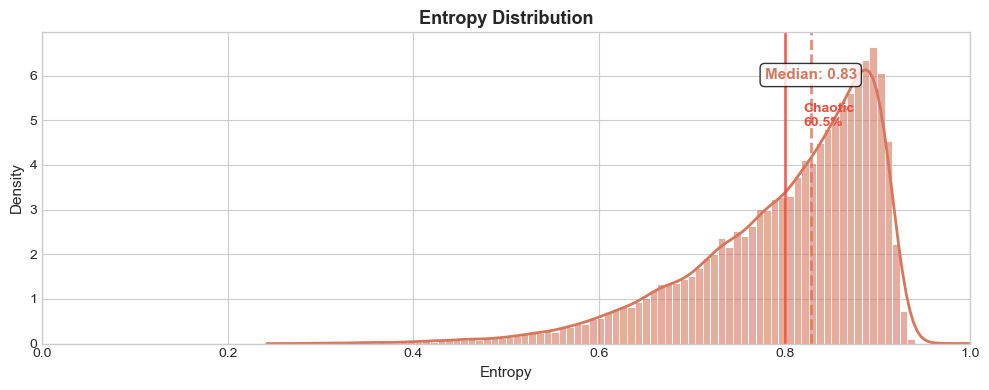

In [11]:
# Histogram of entropy
# High entropy = coin flip; Low entropy = predictable patterns
plot_metric_distribution(diagnostics, 'entropy')

### 5.2 ADI (Intermittency)

**What it measures:** How often demand occurs (gaps between non-zero sales).

- ADI = 1.0 means demand every period (no zeros)
- ADI = 2.0 means demand every other period on average
- ADI > 1.32 is the classic threshold for "intermittent" demand

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'ADI (Average Demand Interval) Distribution'}, xlabel='Adi', ylabel='Density'>)

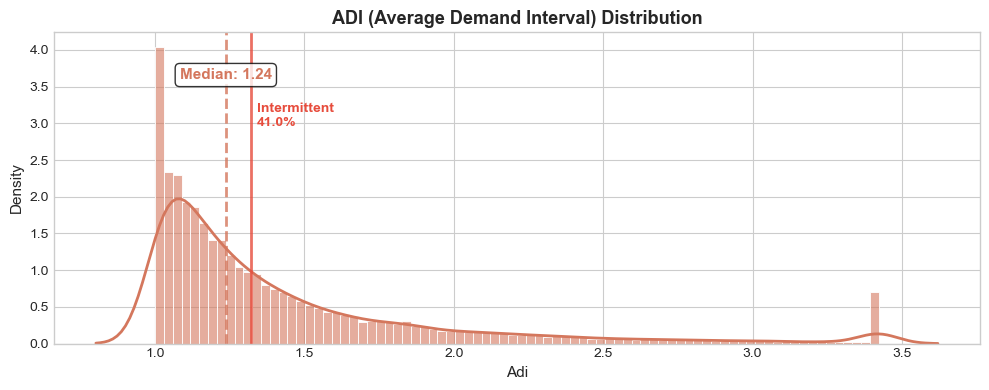

In [12]:
# Histogram of zero_pct or intermittency metric
# How many series are sparse?
plot_metric_distribution(diagnostics, 'adi')

### 5.3 Lumpiness 

**What it measures:** Variance instability, not demand size and not trend.

Two series can have:
- the same mean
- the same overall variance

…but behave very differently over time.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Lumpiness Distribution'}, xlabel='Lumpiness', ylabel='Density'>)

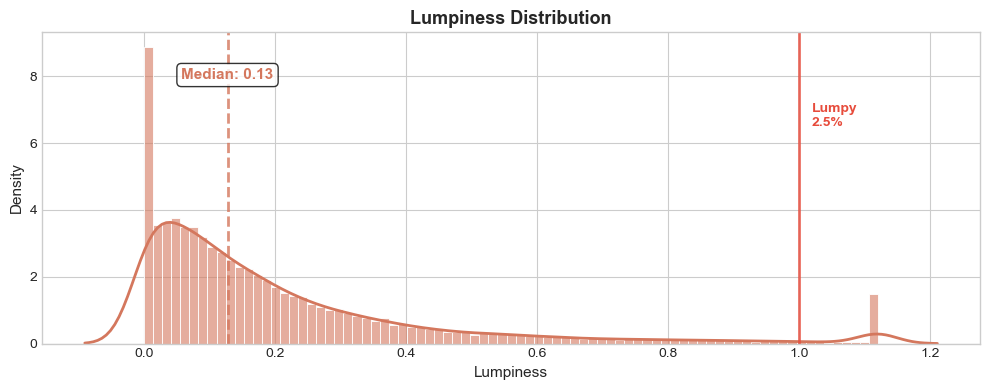

In [13]:
plot_metric_distribution(diagnostics, 'lumpiness')

### 5.3 CV² (Demand Variability)

**What it measures:** Demand volatility

CV² = (std / mean)² measures the volatility of non-zero demand sizes:
- **CV² < 0.49** → Smooth demand (stable sizes)
- **CV² ≥ 0.49** → Erratic demand (volatile sizes)

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'CV² (Squared Coefficient of Variation) Distribution'}, xlabel='Cv2', ylabel='Density'>)

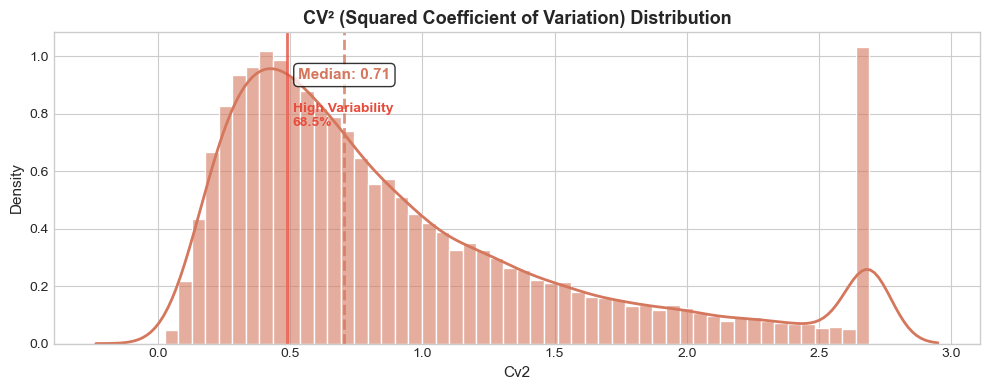

In [14]:
# Overall demand variability
plot_metric_distribution(diagnostics, 'cv2')

---
<div style="text-align: center;">

## 6. Portfolio Summary



### 6.1 By Category

Do different categories have different diagnostic profiles?

In [15]:
from tsforge.display import style_heatmap_table

display(style_heatmap_table(
    diagnostics, 'cat_id', KEY_METRICS,
    'Mean Diagnostics by Category'
))

,trend,seasonal_strength,entropy,adi,cv2
cat_id,,,,,
HOBBIES,0.332,0.559,0.838,1.625,1.248
HOUSEHOLD,0.357,0.572,0.820,1.520,1.038
FOODS,0.445,0.598,0.776,1.339,0.878


### 6.2 By Department

In [16]:
display(style_heatmap_table(
    diagnostics, 'dept_id', KEY_METRICS,
    'Mean Diagnostics by Department'
))

,trend,seasonal_strength,entropy,adi,cv2
dept_id,,,,,
HOBBIES_1,0.345,0.542,0.826,1.484,0.991
HOBBIES_2,0.297,0.607,0.871,2.017,1.965
HOUSEHOLD_1,0.430,0.596,0.792,1.304,0.737
HOUSEHOLD_2,0.283,0.547,0.849,1.743,1.348
FOODS_1,0.358,0.539,0.803,1.372,1.004
FOODS_2,0.475,0.641,0.777,1.408,0.934
FOODS_3,0.454,0.592,0.768,1.297,0.818


---


<div style="text-align: center;">

## 7. Wrap-Up


### 7.1 Log Decisions

| Step | Decision | Why |
|------|----------|-----|
| TS diagnostics | tsfeatures (freq=52) | 43 structural metrics in one call |
| Intermittency | ADI from tsforge | tsfeatures lacks demand-interval metrics |
| Variability | CV² custom calculation | Scale-independent volatility measure |
| Binning | Low/Med/High thresholds | Simplify 45 metrics into actionable profile |

### 7.2 Generate Report

In [17]:
report_1_09 = ModuleReport(
    "1.09",
    input_df=weekly_df,
    output_df=diagnostics,
)

report_1_09.display()

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1.09 · Diagnostics
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

SNAPSHOT
─────────────────────────────────────────────────────────────────
       unique_id    trend  seasonal_strength  entropy      adi      cv2
FOODS_1_001_CA_1 0.204450           0.376623 0.850729 1.105469 0.505594
FOODS_1_001_CA_2 0.223280           0.439298 0.843529 1.105469 0.503956
FOODS_1_001_CA_3 0.162804           0.384099 0.895521 1.118577 0.636649

DATA SUMMARY
─────────────────────────────────────────────────────────────────
  Series diagnosed  30,490
  Metrics computed  50
  Source            1.08 Data Preparation

MEMORY
─────────────────────────────────────────────────────────────────
  ✓ 13 MB (Small) — Fits easily in memory

DIAGNOSTIC PROFILE
─────────────────────────────────────────────────────────────────
                        Low      Medium     High
  STRUCTURE (▲ high = more signal)
    Trend                Lo

### 7.3 Save

In [ ]:
# Save diagnostics for downstream modules
output.save(df=diagnostics, report=report_1_09)

✓ Report saved: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data/output/reports/1.09_diagnostics_report.txt
✓ Saved '1.09_diagnostics'
   Data:   data/1.09_diagnostics_output.parquet (8.39 MB, 30,490 rows)
   Report: reports/1.09_diagnostics_report.txt


PosixPath('/Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data/output/data/1.09_diagnostics_output.parquet')

### 7.4 Next Steps

| Module | Focus |
|--------|-------|
| **1.10** | The Lie Detector 6 — Do these metrics tell the whole truth? |
| **1.11** | Scoring & Segmentation — Build the Structure × Chaos portfolio map |
| **1.12** | Portfolio Architecture — Assign forecastability lanes, select heroes |